# Notebook for single trial PCA
## single reach control trials only (no laser), 50ms before lift to 300ms after lift
## Applying Kalman filter (Q=1e-3, no baseline firing rate)

In [1]:
from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter, get_trial_PCA
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from matplotlib import colormaps

In [2]:
mat = loadmat("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt2.mat")
mat = mat['data']

print(mat.dtype.names)

('totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success')


In [3]:
data_struct = mat[0, 0]  # MATLAB structs are 2D arrays even if 1x1
data = {field: data_struct[field] for field in mat.dtype.names}

In [4]:
data.keys()

dict_keys(['totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success'])

# Visualize the patterns

In [5]:
# visualize the patterns again
# pattern_ids = list(np.unique(data['pattern_id']))
# len(pattern_ids)

In [6]:
# #reshape_size = 12
# pattern_ids = list(np.unique(data['pattern_id']))
# all_patterns = list()
# # pattern 0 = no laser
# all_patterns.append(np.zeros((12, 12)))
# # pattern 1 = full field
# all_patterns.append(np.ones((12, 12)))
# # pattern 2 = empty field 
# all_patterns.append(np.zeros((12, 12)))
# for p_id in pattern_ids[3:]:
#     ix = np.where(data['pattern_id'] == p_id)[0][0].astype(np.int32)
#     pattern = np.zeros((data['pattern_xy'][ix][0].astype(np.int32), data['pattern_xy'][ix][1].astype(np.int32)))
#     # use the pattern fill to set elements to one
#     object_ref = data['pattern_fill'][0][ix]
#     for x, y in zip(object_ref[:, 0], object_ref[:, 1]):
#         pattern[x.astype(np.int32)-1, y.astype(np.int32)-1] = 1

#     all_patterns.append(pattern)

#     #pattern = zoom(pattern, (reshape_size / pattern.shape[0], reshape_size / pattern.shape[1]), order=0)

#     #interp_patterns.append(pattern)

In [7]:
#len(all_patterns)

In [8]:
# fig, axes = plt.subplots(5, 6, figsize=(14, 10))

# # Flatten axes array for easy iteration
# axes = axes.flatten()

# for i, array in zip(range(len(all_patterns)), all_patterns):
#     ax = axes[i]
#     ax.imshow(array, cmap="binary", vmin=0, vmax=1)

#     ax.set_title(f"Pattern {i}") 

# #plt.gca().invert_yaxis() 
# # Adjust layout
# plt.tight_layout()

# #plt.savefig("/home/clewis/repos/realSpike/data/rb50_20250127/patterns.png")

# # Show the plot
# plt.show()

# Get single-reach control trials (no laser)

In [9]:
# get no laser trials
control_idxs = np.where(data["pattern_id"][:150] == 0)[0] 

In [10]:
#control_idxs = np.sort(np.concatenate((a, b)))
control_idxs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  21,  27,  33,  39,  45,  51,  57,  63,  69,  75,
        81,  87,  93,  99, 105, 111, 117, 123, 129, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149])

### Only want to look at single reach trials

In [11]:
single_idxs = np.where(data["single"] == 1)[1]
single_idxs

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  15,
        16,  17,  18,  19,  20,  21,  23,  24,  26,  30,  33,  36,  37,
        38,  39,  40,  41,  43,  44,  45,  46,  48,  49,  50,  51,  52,
        53,  54,  58,  60,  61,  62,  63,  67,  68,  69,  70,  71,  73,
        74,  77,  78,  81,  82,  84,  85,  88,  89,  91, 105, 107, 109,
       116, 117, 121, 122, 130, 137, 139, 145, 148])

In [12]:
control_idxs = np.intersect1d(control_idxs, single_idxs)
control_idxs

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  15,
        21,  33,  39,  45,  51,  63,  69,  81, 105, 117, 137, 139, 145,
       148])

In [13]:
control_idxs.shape

(27,)

## Get relevant time information

In [14]:
cue_times = data["cue_rec_time"][:, :150]
cue_times[:, control_idxs]

array([[  14310.86566601,   31635.98602851,   66118.75767016,
          83391.57934485,  100671.38676484,  117878.88228075,
         135202.39780987,  152469.08335693,  169748.98517889,
         187076.46559048,  221580.66647786,  256113.84876805,
         343834.9853677 ,  447413.10299254,  654737.65694326,
         758001.60483338,  861313.50892099,  964758.89738507,
        1172344.18955914, 1276101.01010101, 1483298.49900878,
        1897560.18125177, 2104905.22042859, 2466558.2932125 ,
        2501046.72897196, 2604792.2212782 , 2656431.70017936]])

In [15]:
lift_times = data["lift_ms"][:, :150]
lift_times[:, control_idxs]

array([[310., 280., 330., 320., 300., 250., 270.,  90., 260., 260., 230.,
        230., 310., 220., 230., 290., 280., 250., 270., 300., 280., 300.,
        200., 290., 340., 250., 220.]])

In [16]:
mouth_times = data["mouth_ms"][:, :150]
mouth_times[:, control_idxs]

array([[540., 540., 560., 570., 520., 540., 600., 460., 510., 490., 500.,
        530., 510., 510., 490., 590., 520., 530., 620., 510., 520., 570.,
        560., 530., 570., 590., 480.]])

In [17]:
grab_times = data["grab_ms"][:, :150]
grab_times[:, control_idxs]

array([[420., 390., 430., 420., 410., 390., 410., 320., 360., 360., 370.,
        400., 400., 360., 360., 390., 370., 390., 400., 400., 400., 480.,
        360., 390., 440., 390., 320.]])

## Get the AP.bin file

In [18]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [19]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [20]:
meta_data = get_meta(meta_path)

In [21]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [22]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [23]:
vmax

0.6

In [24]:
imax

512.0

In [25]:
gain

500.0

## Get first trial

#### 50ms before "lift" to 300ms after lift 

In [44]:
trial_no = 0

In [45]:
# get the lift time in ap units 
# cue + lift time (ms) / 1000 = s * 30_000 (sR) 
start_lift = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)

# get end of behavior = mouth (260ms) + 300ms 
end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260 + 300) / 1_000 * 30_000)
(start_lift, end_behavior)

(437125, 462325)

## Get entire behavior segment

In [46]:
trial_one = ap_data[:150, start_lift:end_behavior]
trial_one.shape

(150, 25200)

# Get median segment
Taking a baseline of 2 seconds of data before cue

In [47]:
c_start = int(cue_times[:, trial_no] / 1_000 * 30_000)
m_start = c_start - (30 * 2000)
trial_median = ap_data[:150, m_start:c_start]
trial_median.shape

(150, 60000)

## Convert to microvolts 

In [48]:
conv_data = 1e6 * trial_one / vmax / imax / gain

In [49]:
conv_data.shape

(150, 25200)

## Filter

In [50]:
filt_data = butter_filter(conv_data, 1_000, 30_000)
filt_data.shape

(150, 25200)

## Median/MAD Threshold 

In [51]:
trial_median = 1e6 * trial_median / vmax / imax / gain
trial_median = butter_filter(trial_median, 1_000, 30_000)

median = np.median(trial_median, axis=1)
median.shape

(150,)

In [52]:
spike_ixs, counts = get_spike_events(filt_data, median)

In [53]:
# create a range of the entire trial time
# binarize the spike times
# bin into 5ms bins (every 150 data points) 

In [54]:
a = np.zeros((filt_data.shape[0], filt_data.shape[1]))

In [55]:
for i, sc in enumerate(spike_ixs):
    a[i, sc] = 1

## Bin the spike data

In [56]:
bin_size = 5 # 10ms * 30 points per 1ms

In [57]:
b = bin_size * 30
binned_spikes = bin_spikes(a, bin_size=b)

In [58]:
binned_spikes.shape

(150, 168)

## Apply kalman filter

In [59]:
smoothed = kalman_filter(binned_spikes)

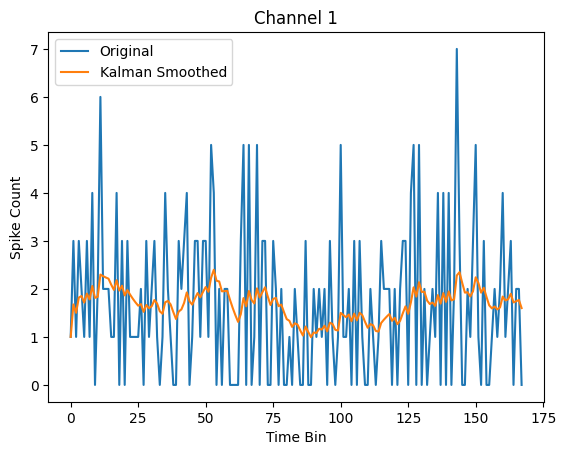

In [60]:
import matplotlib.pyplot as plt

plt.plot(binned_spikes[1], label='Original')
plt.plot(smoothed[1], label='Kalman Smoothed')
plt.legend()
plt.title('Channel 1')
plt.xlabel('Time Bin')
plt.ylabel('Spike Count')
plt.show()

In [61]:
smoothed.shape

(150, 168)

In [62]:
# lift duration
lift = int(data["lift_ms"][0,trial_no] / bin_size) 
# grab duration
grab = int(data["grab_ms"][0,trial_no] / bin_size)
# mouth duration 
mouth = int(data["mouth_ms"][0,trial_no] / bin_size)

(lift, grab, mouth)

(62, 84, 108)

# PCA only on 50ms before lift to 300ms after lift

In [63]:
pca = PCA(n_components=6)

# Fit the PCA model to the data and transform the data
# only fit the PCA on 50ms before lift to end of lift 
lift_start = int(50 / bin_size)
after_lift = int(300 / bin_size) + lift_start

#d = smoothed - smoothed.mean(axis=1, keepdims=True)

#d = smoothed[:,:after_lift] - smoothed[:,:after_lift].mean(axis=1, keepdims=True)

pca.fit(smoothed[:, :after_lift].T)
reduced_data = pca.transform(smoothed.T)

print("Explained variance ratio by each principal component:", pca.explained_variance_ratio_)
print("Total explained variance ratio", pca.explained_variance_ratio_[:3].sum())

Explained variance ratio by each principal component: [0.62441351 0.17336345 0.05778314 0.04531698 0.02734435 0.01374718]
Total explained variance ratio 0.8555600939588284


In [64]:
reduced_data.shape

(168, 6)

# Plot single trial in 2D

Explained variance ratio by each principal component: [0.62441351 0.17336345 0.05778314 0.04531698 0.02734435 0.01374718]
Total explained variance (top 3 PCs): 0.8555600939588284


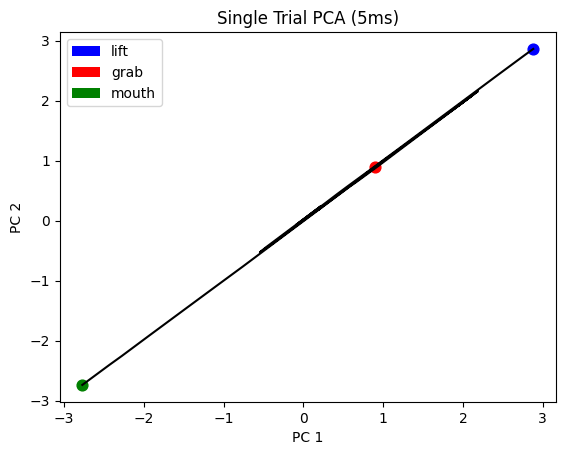

In [67]:
# Print explained variance ratio
print("Explained variance ratio by each principal component:", pca.explained_variance_ratio_)
print("Total explained variance (top 3 PCs):", pca.explained_variance_ratio_[:3].sum())


mouth_start = lift_start + (mouth-lift)

# # Visualize the reduced data (scatter plot)
p = gaussian_filter1d(reduced_data, sigma=5)
#p = reduced_data
plt.plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], c="black")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title(f"Single Trial PCA ({bin_size}ms)")

plt.scatter(p[lift_start, 0], p[lift_start, 1], s=60, c="blue")
plt.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], s=60, c="red")
plt.scatter(p[mouth_start, 0], p[mouth_start, 1], s=60, c="green")

from matplotlib.patches import Patch

# Sample color mapping
c = {'lift': 'blue', 'grab': 'red', 'mouth': 'green'}

# Manual legend
legend_elements = [Patch(facecolor=color, label=beh) for beh, color in c.items()]
plt.legend(handles=legend_elements)
plt.show()

# Plot single trial in 3D

Explained variance ratio by each principal component: [0.62323128 0.1951556  0.09732676 0.05263417 0.0188416  0.00950042]
Total explained variance (top 3 PCs): 0.91571


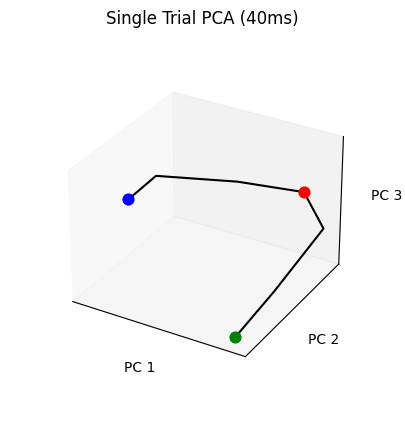

In [48]:
# Print explained variance ratio
print("Explained variance ratio by each principal component:", pca.explained_variance_ratio_)
print("Total explained variance (top 3 PCs):", round(pca.explained_variance_ratio_[:3].sum(), 5))

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')


mouth_start = lift_start + (mouth-lift)

# # Visualize the reduced data (scatter plot)
#p = gaussian_filter1d(reduced_data, sigma=3)
p = reduced_data
ax.plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], p[lift_start:mouth_start+1, 2], c="black")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title(f"Single Trial PCA ({bin_size}ms)")

ax.scatter(p[lift_start, 0], p[lift_start, 1], p[lift_start, 2], s=60, c="blue")
ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=60, c="red")
ax.scatter(p[mouth_start, 0], p[mouth_start, 1], p[mouth_start, 2], s=60, c="green")

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# from matplotlib.patches import Patch

# # Sample color mapping
# c = {'lift': 'blue', 'grab': 'red', 'mouth': 'green'}

# # Manual legend
# legend_elements = [Patch(facecolor=color, label=beh) for beh, color in c.items()]
# plt.legend(handles=legend_elements)
ax.set_box_aspect(None, zoom=0.8)
plt.show()

# Run PCA on all the trials

In [68]:
all_data = list()
#explained_variances = list()

# HYPERPARAMETERS TO TOGGLE
bin_size = 5
Q=1e-2

for i in tqdm(control_idxs):
    trial_no = i
    # get time points in ap space
    lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
    
    # get end of behavior = mouth (260ms) + 300ms 
    end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260 + 300) / 1_000 * 30_000)
    #print(lift_time, end_behavior)

    trial = ap_data[:150, lift_time:end_behavior]

    conv_data = 1e6 * trial / vmax / imax / gain

    filt_data = butter_filter(conv_data, 1_000, 30_000)

    c_start = int(cue_times[:, trial_no] / 1_000 * 30_000)
    m_start = c_start - (30 * 2000)
    trial_median = ap_data[:150, m_start:c_start]

    trial_median = 1e6 * trial_median / vmax / imax / gain
    trial_median = butter_filter(trial_median, 1_000, 30_000)
    
    median = np.median(trial_median, axis=1)

    spike_ixs, counts = get_spike_events(filt_data, median)
    
    a = np.zeros((filt_data.shape[0], filt_data.shape[1]))

    for i, sc in enumerate(spike_ixs):
        a[i, sc] = 1

    b = bin_size * 30 # 30ms per bin
    binned_spikes = bin_spikes(a, b)

    smoothed = kalman_filter(binned_spikes, Q=Q)

    all_data.append(smoothed)

100%|█████████████████████████████████| 27/27 [00:21<00:00,  1.24it/s]


In [69]:
pca = PCA(n_components=6)

pca_data = list()

lift_start = int(50 / bin_size)
after_lift = int(300 / bin_size) + lift_start

for d in all_data:
    pca_data.append(d[:, lift_start:after_lift+1])

d = np.concatenate(pca_data, axis=1)
    
pca.fit(d.T)

pca.explained_variance_ratio_

array([0.38443869, 0.14657028, 0.05078084, 0.04030525, 0.03353521,
       0.02380525])

In [70]:
pca.explained_variance_ratio_[:3].sum()

0.5817898137728015

0.018956480089902413


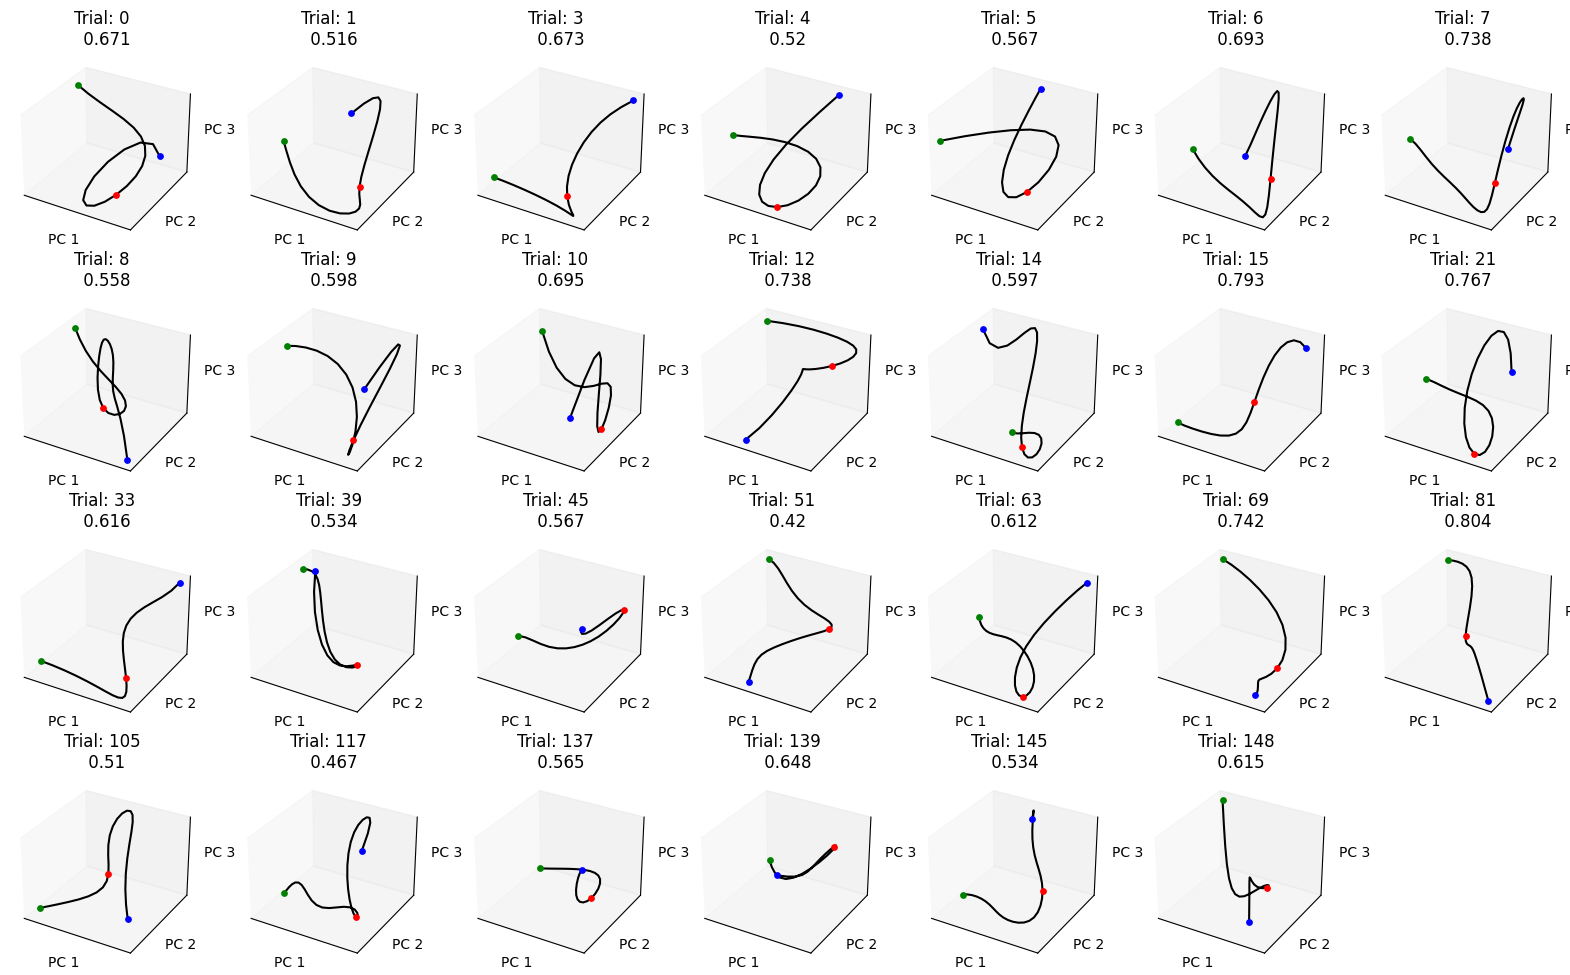

In [40]:
fig, axes = plt.subplots(4, 7, figsize=(20, 12), subplot_kw=dict(projection='3d'))

# Flatten axes array for easy iteration
axes = axes.flatten()

third_comp = list()

for i, p in enumerate(all_data):

    explained_var, p = get_trial_PCA(p, pca)
    third_comp.append(explained_var[-1])
    
    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
    mouth_start = lift_start + (mouth-lift)

    # p = gaussian_filter1d(p, sigma=0.05)
    p = gaussian_filter1d(p, sigma=3, axis=0)

    #axes[i].scatter(p[:, 0], p[:, 1], s=1, c=colors)
    axes[i].plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], p[lift_start:mouth_start+1, 2], c="black")
    axes[i].set_xlabel(f"PC 1", labelpad=-7)
    axes[i].set_ylabel(f"PC 2", labelpad=-7)
    axes[i].set_zlabel(f"PC 3", labelpad=-7)
    axes[i].set_title(f"Trial: {control_idxs[i]} \n {round(explained_var.sum(), 3)}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_zticks([])


    axes[i].scatter(p[lift_start, 0], p[lift_start, 1], p[lift_start, 2], s=15, c="blue")
    axes[i].scatter(p[grab_start, 0], p[grab_start, 1], p[grab_start, 2], s=15, c="red")
    axes[i].scatter(p[mouth_start, 0], p[mouth_start, 1], p[mouth_start, 2], s=15, c="green")

axes[-1].remove() 

print(sum(third_comp) / len(third_comp))

plt.savefig(f'/home/clewis/repos/realSpike/data/rb50_20250127/PCA_control_{bin_size}ms_3d.png')

# Plot first 2 PCs

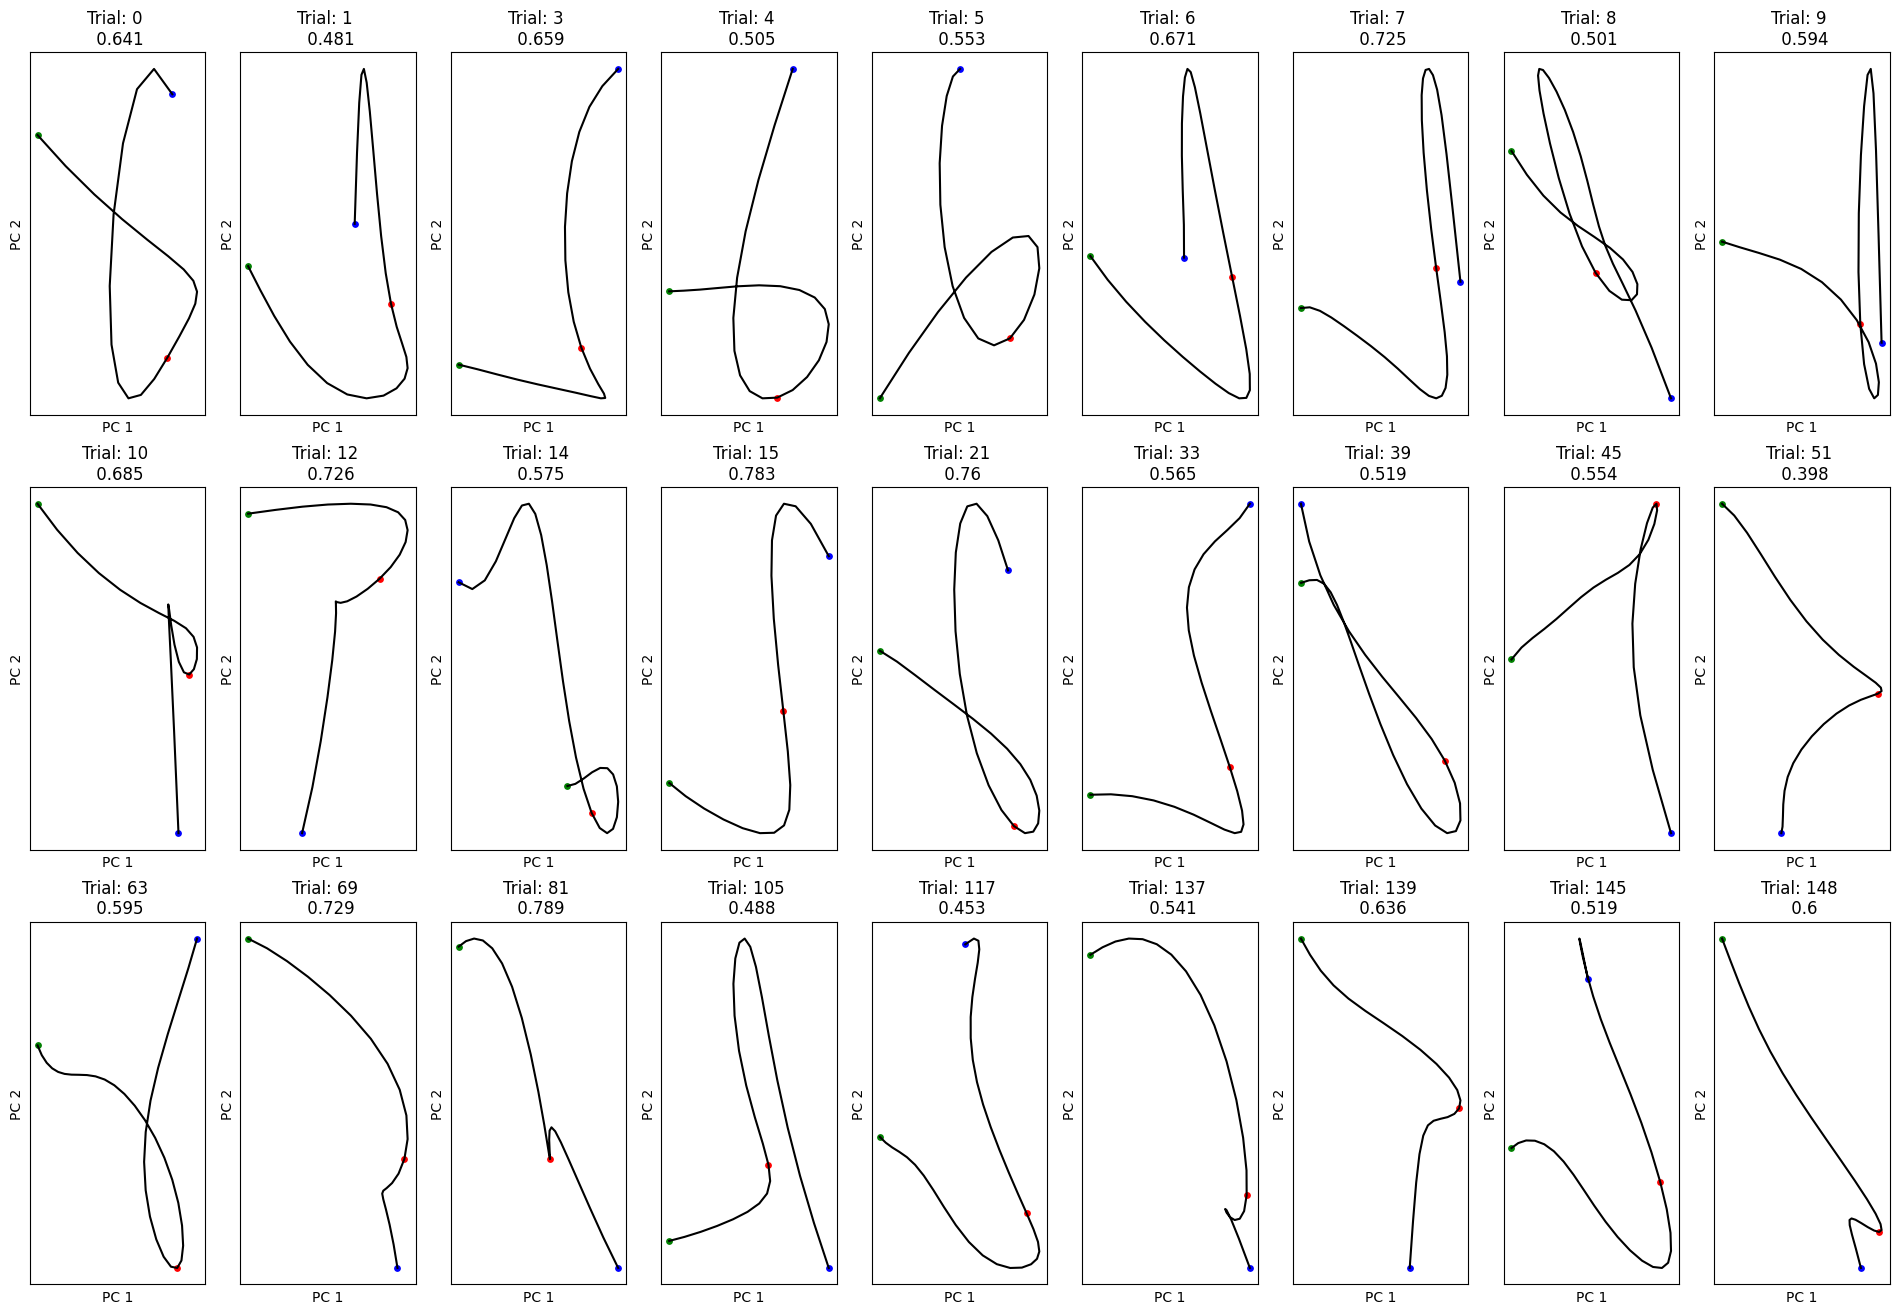

In [41]:
fig, axes = plt.subplots(3, 9, figsize=(24, 16))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, p in enumerate(all_data):

    explained_var, p = get_trial_PCA(p, pca, 2)
    
    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
    mouth_start = lift_start + (mouth-lift)

    # p = gaussian_filter1d(p, sigma=0.05)
    p = gaussian_filter1d(p, sigma=3, axis=0)

    #axes[i].scatter(p[:, 0], p[:, 1], s=1, c=colors)
    axes[i].plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], c="black")
    axes[i].set_xlabel(f"PC 1")
    axes[i].set_ylabel(f"PC 2")
    axes[i].set_title(f"Trial: {control_idxs[i]} \n {round(explained_var.sum(), 3)}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])


    axes[i].scatter(p[lift_start, 0], p[lift_start, 1], s=15, c="blue")
    axes[i].scatter(p[grab_start, 0], p[grab_start, 1], s=15, c="red")
    axes[i].scatter(p[mouth_start, 0], p[mouth_start, 1], s=15, c="green")

#axes[-1].remove() 

plt.savefig(f'/home/clewis/repos/realSpike/data/rb50_20250127/PCA_control_{bin_size}ms_2d.png')

# Plot all of them together

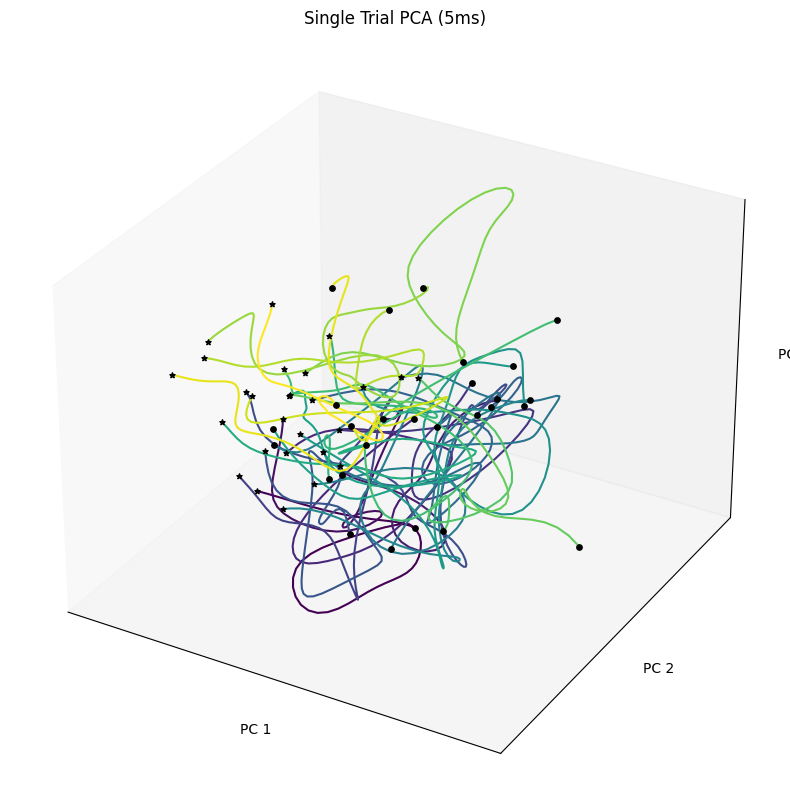

In [71]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

n_colors = len(all_data)
cmap = colormaps['viridis']
colors = cmap(np.linspace(0, 1, n_colors))

for i, p in enumerate(all_data):

    explained_var, p = get_trial_PCA(p, pca)
    
    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
    mouth_start = lift_start + (mouth-lift)

    # p = gaussian_filter1d(p, sigma=0.05)
    p = gaussian_filter1d(p, sigma=3, axis=0)
    
#p = reduced_data
    ax.plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], p[lift_start:mouth_start+1, 2], c=colors[i])

    ax.scatter(p[lift_start, 0], p[lift_start, 1], p[lift_start, 2], s=15, c="black")
    #ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=10, c="red")
    ax.scatter(p[mouth_start, 0], p[mouth_start, 1], p[mouth_start, 2], s=15, marker="*", c="black")


ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title(f"Single Trial PCA ({bin_size}ms)")



ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# from matplotlib.patches import Patch

# # Sample color mapping
# c = {'lift': 'blue', 'grab': 'red', 'mouth': 'green'}

# # Manual legend
# legend_elements = [Patch(facecolor=color, label=beh) for beh, color in c.items()]
# plt.legend(handles=legend_elements)
#ax.set_box_aspect(None, zoom=0.8)
plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/PCA_control_all_{bin_size}_3d.png")
plt.show()

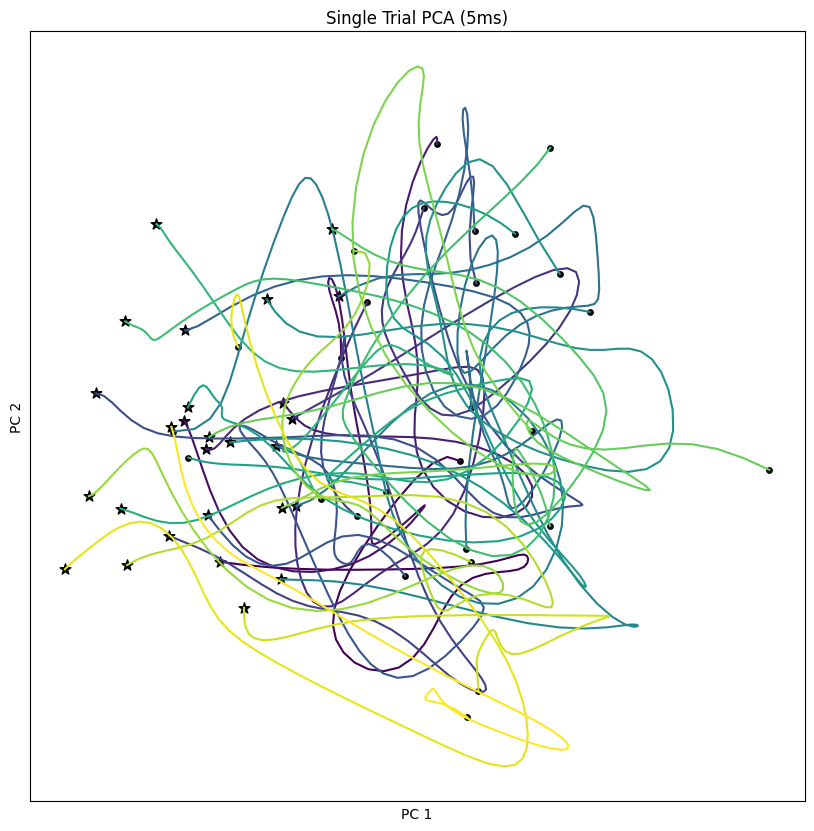

In [72]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

n_colors = len(all_data)
cmap = colormaps['viridis']
colors = cmap(np.linspace(0, 1, n_colors))


for i, p in enumerate(all_data):

    explained_var, p = get_trial_PCA(p, pca)
    
    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
    mouth_start = lift_start + (mouth-lift)

    # p = gaussian_filter1d(p, sigma=0.05)
    p = gaussian_filter1d(p, sigma=3, axis=0)
    
#p = reduced_data
    ax.plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], c=colors[i])

    ax.scatter(p[lift_start, 0], p[lift_start, 1], s=15, c="black")
    #ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=10, c="red")
    ax.scatter(p[mouth_start, 0], p[mouth_start, 1], s=65, marker='*', c="black")


ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title(f"Single Trial PCA ({bin_size}ms)")



ax.set_xticks([])
ax.set_yticks([])

# from matplotlib.patches import Patch

# # Sample color mapping
# c = {'lift': 'blue', 'grab': 'red', 'mouth': 'green'}

# # Manual legend
# legend_elements = [Patch(facecolor=color, label=beh) for beh, color in c.items()]
# plt.legend(handles=legend_elements)
#ax.set_box_aspect(None, zoom=0.8)
plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/PCA_control_all_{bin_size}_2d.png")
plt.show()